# Euler characteristic integration error behaviour

Let's now explore the error behaviour of the topological target counting algorithm in a more structured way. We do this by creating micro-examples of (mis)counting to determine what's causing the issues.

In [1]:
from itertools import combinations
from copy import deepcopy
import numpy
from numpy.linalg import norm
from numpy.random import rand

from sensorplayground import SensorPlayground, SimpleSensor, EulerEstimator, drawField, zipboth
from simplicial import SimplicialComplex, SimplicialFunction, Embedding, EulerIntegrator, k_simplex, TriangularLattice, TriangularLatticeEmbedding
from simplicial.drawing import drawComplex, drawEulerIntegral

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt

plt.style.use(['default', 'display.mplstyle'])

We will use a standard colourmap for the counts metric.

In [2]:
cmap = matplotlib.colormaps['Set1']

We need a function to offset points, for positioning targets relative to sensors.

In [3]:
def offset(pos, s, off):
    '''Return a point offset from a sensor's position.

    :param pos: the embedding
    :param s: the simplex
    :param off: the offset
    :returns: the position'''
    return list(map(lambda po: po[0] + po[1], zip(e[s], off)))

We will also draw the sensor field and overhearing complex in a standard way, with a colourbar to indicate the count values.

In [25]:
def drawFieldAndOverhearing(pg, overhearing, embedding, metric, ts = None, axs = None, cax = None, cmap = None):
    '''Draw the sensor field and its overhearing complex side by side.

    :param pg: the playground
    :param overhearing: the overhearing complex
    :param embedding: the embedding of the complex
    :param metric: the counting metric
    :param ts: (optional) target positions
    :param axs: (optional) array of at least 3 axes (defaults to create a new figure)
    :param cax: (optional) axes to draw colourbar into (defaults to None)
    :param cmap: (optional) colourmap'''

    # fill in defaults
    if axs is None:
        # default is a side-by-side plot with a narrow colourbar on the right
        _, axs = plt.subplots(nrows=1, ncols=3, width_ratios=[0.49, 0.49, 0.02], figsize=(6, 2))
        cax = axs[-1]
    if cmap is None:
        cmap = matplotlib.colormaps['Set1']
        
    # sensor colours dict, derived from the metric
    col = {}
    for s in pg:
        col[s.id()] = cmap(metric[s.id()])
    
    # draw the sensor field
    drawField(pg, ts=ts, ax=axs[0],
              showSensorLabels=False, showSensorFields=True,
              showSensors=True, sensorColour='k', sensorSize=10, sensorFilled=True, sensorFillColour=col,
              showTargets=True, targetMarker='o', targetColour='k')
    axs[0].set_title('Sensor field')

    # draw the overhearing complex
    drawComplex(overhearing, embedding, ax=axs[1],
                sf=metric, simplexColour=cmap)
    axs[1].set_title('Overhearing complex')

    # draw the colourbar if requested
    if cax is not None:
        highest = max([metric[s.id()] for s in pg])
        bounds = list(range(highest + 1))
        norm = matplotlib.colors.BoundaryNorm(bounds, highest + 1)
        cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                            location='right',
                            cax=cax,
                            ticks=[i + 0.49 for i in bounds[:-1]],
                            drawedges=True,
                            label='Target count',
                            format='{x:.0f}')

## Micro examples

### One triangle, two targets

In [5]:
# create an embedded complex that represents a triangle
c = SimplicialComplex()
e = Embedding(c)
n1 = c.addSimplex(id = 1)
n2 = c.addSimplex(id = 2)
n3 = c.addSimplex(id = 3)
e1 = c.addSimplex(fs=[n1, n2], id = 12)
e2 = c.addSimplex(fs=[n1, n3], id = 13)
e3 = c.addSimplex(fs=[n2, n3], id = 23)
t1 = c.addSimplex(fs=[e1, e2, e3], id = 123)
e[n1] = (0.4, 0.4)
e[n2] = (0.4, 0.5)
e[n3] = (0.5, 0.4)

We then create a sensor field with sensors positioned according to this embedded complex.

In [6]:
oneTriangle = SensorPlayground()
for n in c.simplicesOfOrder(0):
    s = SimpleSensor(0.15, id=n)
    oneTriangle.addSensor(s, e[n])

Add two targets in the same triangle.

In [7]:
g1 = offset(e, n1, (0.02, 0.02))
g2 = offset(e, n2, (0.02, -0.02))

In [8]:
oneTriangleEstimator = EulerEstimator(oneTriangle)
oneTriangleCountTargets = oneTriangleEstimator.estimateFromTargets([g1, g2])

In [9]:
isinstance(cmap, matplotlib.colors.Colormap)

True

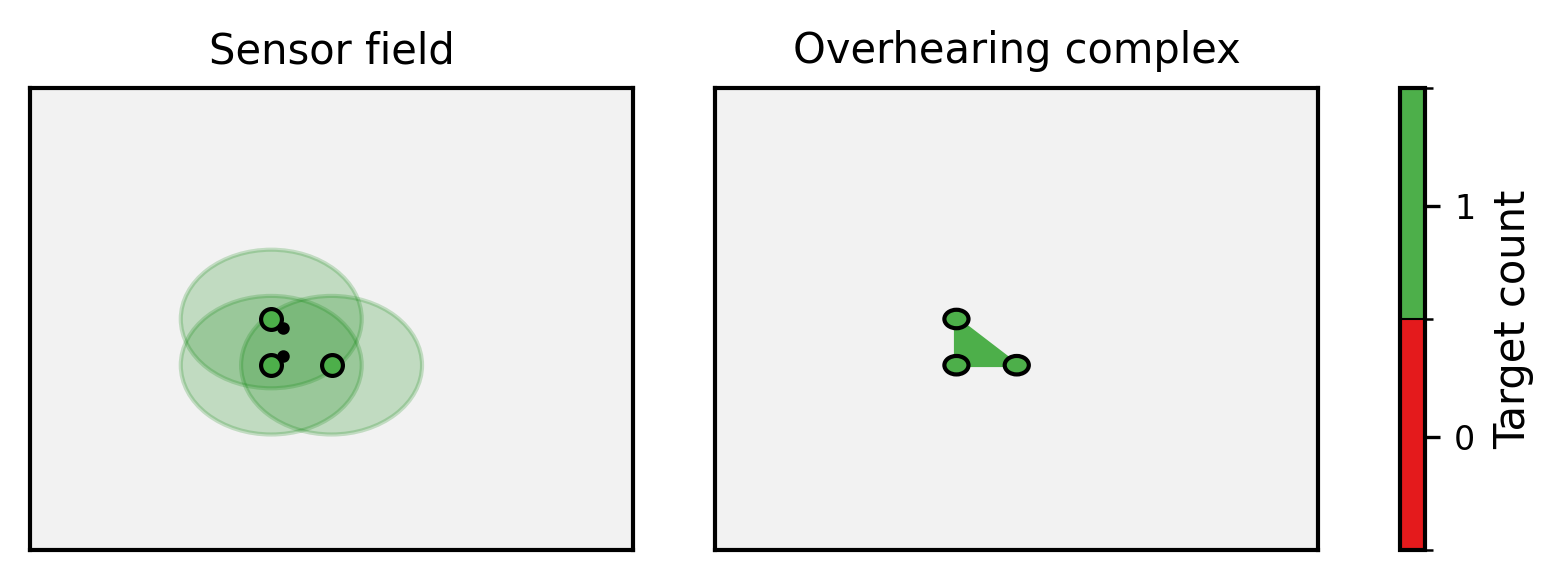

In [26]:
drawFieldAndOverhearing(oneTriangle, oneTriangleEstimator.overhearing(), e, oneTriangleEstimator.metric(),
                        ts=[g1, g2],
                        cmap=cmap)

In [11]:
print(f'Counting {oneTriangleCountTargets} targets')

Counting 2 targets


### Two triangles, two targets

In [12]:
# add a second triangle
ss = c.basisOf(t1)
n4 = c.addSimplex(id=4)
t2 = c.addSimplexWithBasis(bs=[n1, n2, n4])
e.positionSimplex(n4, (0.5, 0.5))

# create a new playground
twoTriangle = deepcopy(oneTriangle)
s = SimpleSensor(0.15, id=n4)
twoTriangle.addSensor(s, e.positionOf(n4))

In [13]:
g3 = offset(e, n4, (-0.02, -0.02))

In [14]:
twoTriangleEstimator = EulerEstimator(twoTriangle)
twoTriangleCountTargets = twoTriangleEstimator.estimateFromTargets([g1, g2, g3])

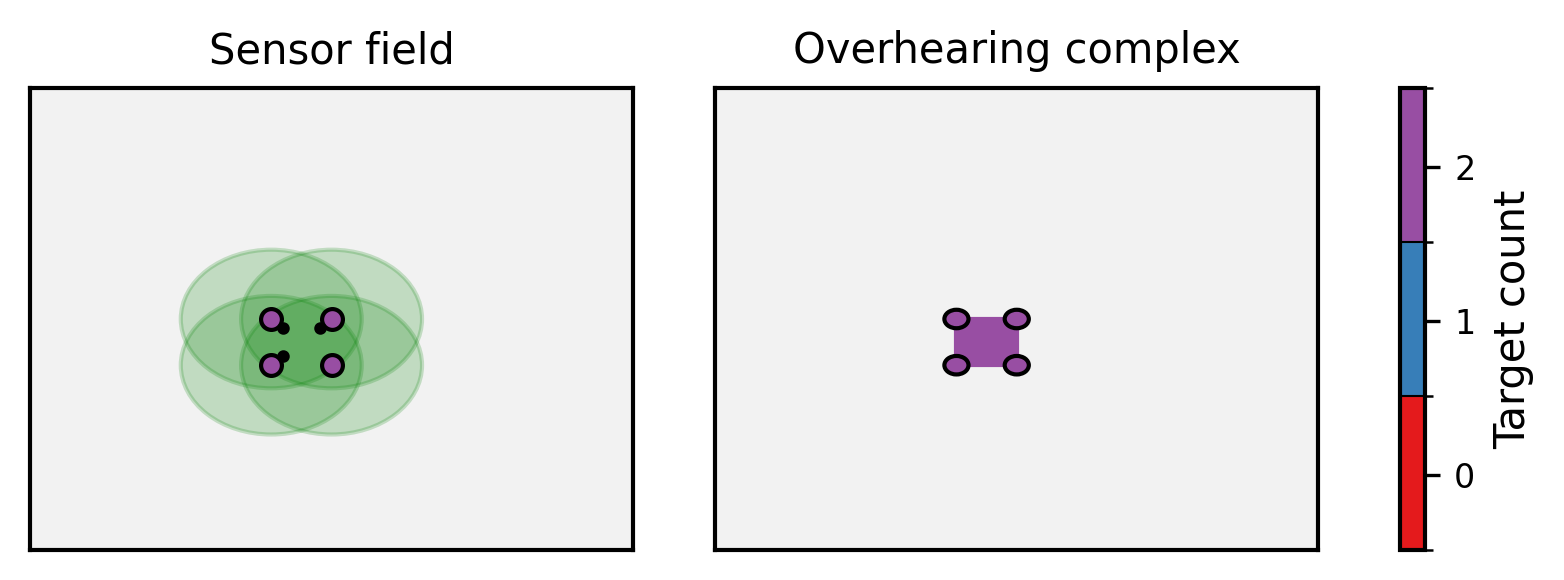

In [27]:
drawFieldAndOverhearing(twoTriangle, twoTriangleEstimator.overhearing(), e, twoTriangleEstimator.metric(),
                        ts=[g1, g2, g3],
                        cmap=cmap)

In [16]:
isinstance(cmap, matplotlib.colors.Colormap)

True

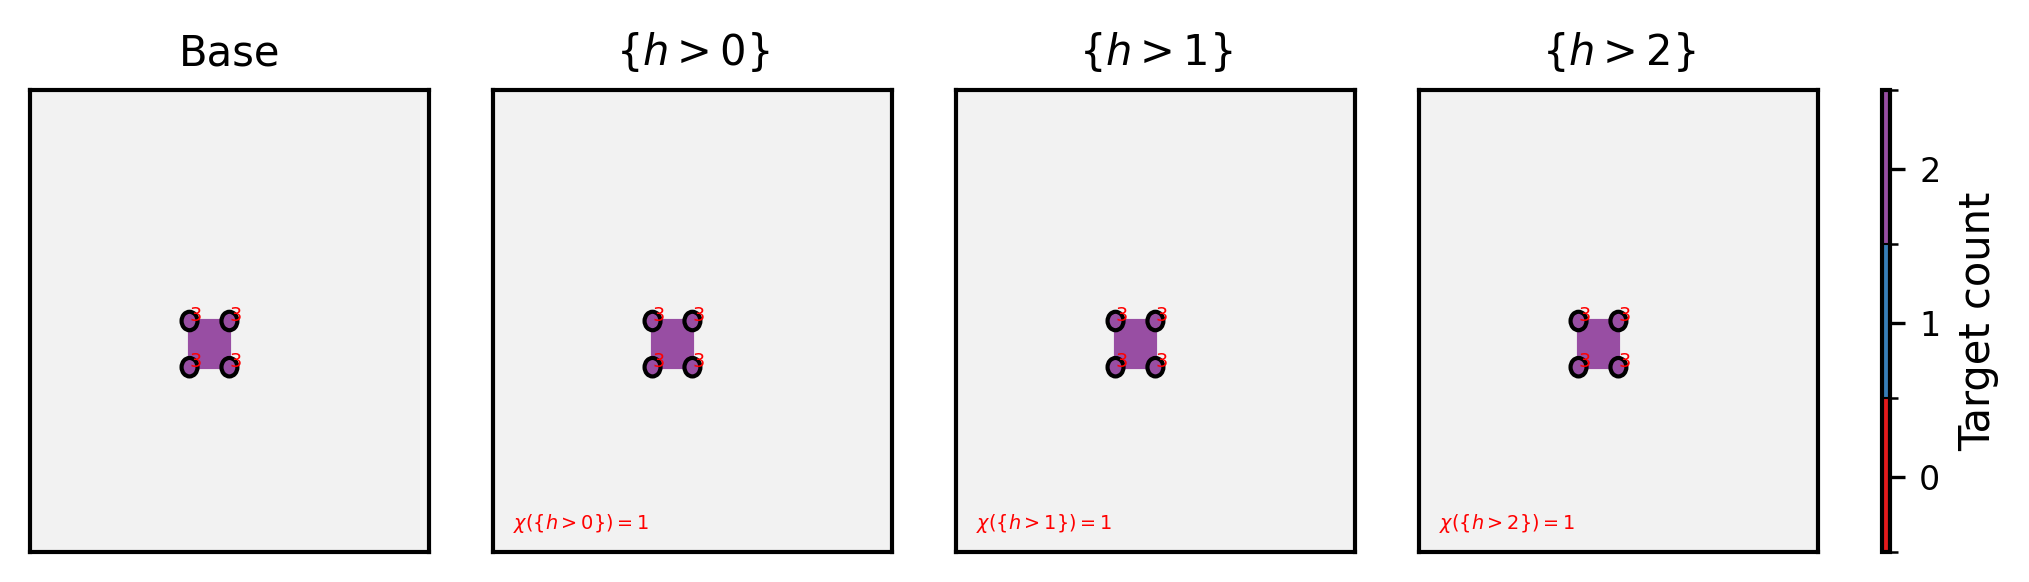

In [24]:
drawEulerIntegral(twoTriangleEstimator.overhearing(), e, sf=twoTriangleEstimator.metric(),
                  showLevelSets=True,
                  showEulerCharacteristics=True, eulerCharacteristicsColour='r', eulerCharacteristicsFontSize='xx-small',
                  showMetrics=True, metricsColour='r', metricsFontSize='xx-small',
                  cmap=cmap)

Essentially the shape of the overhearing complex is a "tower" of height 3.

### One tetrahedron with targets in two different triangles

In [18]:
# there should be an easier way of doing this....
n5 = c.addSimplex(id=5)
e4 = c.addSimplex(fs=[n1, n5], id = 15)
e5 = c.addSimplex(fs=[n2, n5], id = 25)
e6 = c.addSimplex(fs=[n3, n5], id = 35)
t2 = c.addSimplex(fs=[e1, e2, e4], id = 124)
t3 = c.addSimplex(fs=[e1, e3, e4], id = 134)
t4 = c.addSimplex(fs=[e2, e3, e4], id = 234)
q1 = c.addSimplex(fs=[t1, t2, t3, t4], id = 1234)

e[n5] = (0.3, 0.6)
oneTetra = deepcopy(twoTriangle)
s = SimpleSensor(0.2, id=n5)                   # slightly wider than the others
oneTetra.addSensor(s, e[n5])

In [19]:
s._detectionRadius = 0.2

In [20]:
oneTetraEstimator = EulerEstimator(oneTetra)
oneTetraCountTargets = oneTetraEstimator.estimateFromTargets([g1, g2, g3])
print(f'Counting {oneTetraCountTargets} targets')

Counting 3 targets


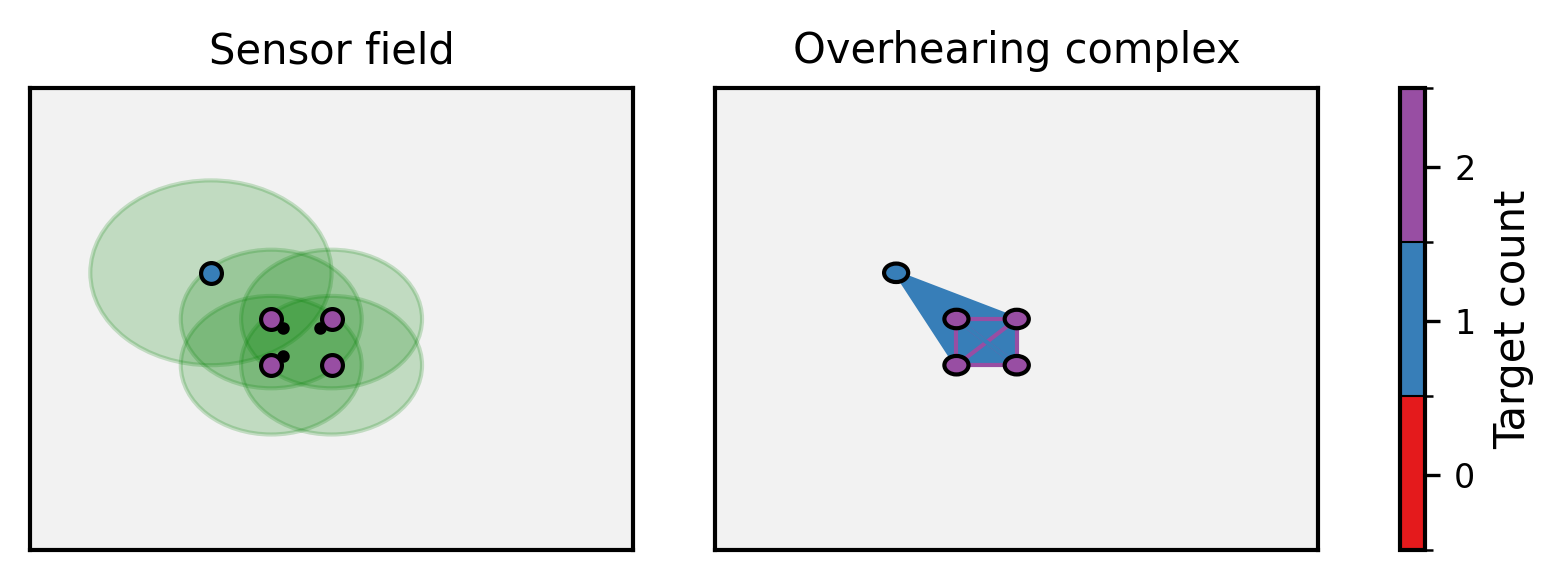

In [21]:
drawFieldAndOverhearing(oneTetra, oneTetraEstimator.overhearing(), e, oneTetraEstimator.metric(),
                        ts=[g1, g2, g3],
                        cmap=cmap)